In [1]:
from modulos import ann, eda, ml_func
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

2025-08-28 11:25:21.501842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# ML - Bacia do Rio Negro 2

Usando a cota de 15 dias anteriores + cota das estações montantes

### Estações

1. Rio Negro

2. Rio Branco


In [2]:
path = 'Cotas extraidas'
date_start = '1985-01-01'
date_end = '2023-12-31'

In [3]:
arquivos = [
    'dados_diarios_estacao_14480002.csv',
    'dados_diarios_estacao_14840000.csv',
    'dados_diarios_estacao_14990000.csv'
]

negro = eda.data_processing(path, date_start, date_end, arquivos)
negro

,14480002,14840000,14990000
Data,,,
1985-01-01,409.0,669.0,2169.0
1985-01-02,411.0,677.0,2178.0
1985-01-03,413.0,681.0,2186.0
1985-01-04,416.0,685.0,2194.0
1985-01-05,427.0,691.0,2201.0
...,...,...,...
2023-12-27,325.0,413.0,1807.0
2023-12-28,329.0,421.0,1822.0
2023-12-29,331.0,427.0,1834.0


In [4]:
arquivos = [
    'dados_diarios_estacao_14620000.csv',
    'dados_diarios_estacao_14710000.csv',
    'dados_diarios_estacao_14790000.csv'
]

branco = eda.data_processing(path, date_start, date_end, arquivos)
branco

,14620000,14710000,14790000
Data,,,
1985-01-01,285.0,281.0,509.0
1985-01-02,309.0,285.0,503.0
1985-01-03,310.0,290.0,498.0
1985-01-04,260.0,293.0,504.0
1985-01-05,259.0,280.0,510.0
...,...,...,...
2023-12-27,83.0,126.0,340.0
2023-12-28,84.0,131.0,339.0
2023-12-29,78.0,137.0,345.0


### Correlação cruzada
Aplicar lags nas estações montantes para verificar qual possui maior correlação com a cota atual

In [5]:
lags_negro = eda.cross_corr(negro, '14990000')

Estação 14480002: Melhor lag = 12; Correlação = 0.7487
Estação 14840000: Melhor lag = 4; Correlação = 0.8751


In [6]:
lags_branco = eda.cross_corr(branco, '14790000')

Estação 14620000: Melhor lag = 8; Correlação = 0.8376
Estação 14710000: Melhor lag = 6; Correlação = 0.8908


### Aprendizado de Máquina

##### Separação dos conjuntos

##### Funções

In [15]:
def train_test_model(models, name_models, df, name_column, date_split, janela, steps, shifts):
    # Dataframe com shifts
    x_shifts = {}
    for i, col in enumerate(df.columns):
        if col == name_column:
            x_shifts[col] = df[col]
        else:
            x_shifts[f"{col} - lag {shifts[i]}"] = df[col].shift(shifts[i])

    x_shifts = pd.DataFrame(x_shifts, index=df.index)
    x_shifts.dropna(inplace=True)

    # Separando conjunto de treino e teste
    x_shifts_treino, x_shifts_teste = x_shifts[x_shifts.index < date_split], x_shifts[x_shifts.index >= date_split]
    split = x_shifts_treino.shape[0]
    
    # Criação de janelas
    X, y = ml_func.create_multi_step_dataset(x_shifts[name_column].values, janela, steps)
    for i, col in enumerate(x_shifts.columns):
        if col == name_column:
            continue
        else:
            x, _ = ml_func.create_multi_step_dataset(x_shifts[col].values, janela, steps)
            X = np.append(X, x, axis=1)

    # Separação dos cojuntos
    x_train = X[:split-janela]
    y_train = y[:split-janela]

    x_test = X[split-janela:]
    y_test = y[split-janela:]

    # Normalização dos dados
    x_scale = MinMaxScaler()
    y_scale = MinMaxScaler()

    x_train = x_scale.fit_transform(x_train)
    x_test = x_scale.transform(x_test)

    y_train = y_scale.fit_transform(y_train)

    # Callback Early Stopping
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Aprendizado
    predicts = []
    for i, model in enumerate(models):
        # Treino
        model.fit(x_train, y_train, epochs=100, verbose=0, callbacks=early_stop)

        # Predição
        pred = model.predict(x_test, verbose=0)
        pred_inv = y_scale.inverse_transform(pred)
        predicts.append(pred_inv)

        # Métricas (média)
        print(f"\nModelo: {name_models[i]}")
        r2 = r2_score(y_test, pred_inv)
        rmse = root_mean_squared_error(y_test, pred_inv)
        mae = mean_absolute_error(y_test, pred_inv)
        mape = mean_absolute_percentage_error(y_test, pred_inv)
        print(f"Médias: R² = {r2:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}, MAPE = {mape*100:.4f}%")

        # Métricas (step)
        s_r2 = r2_score(y_test[:, steps-1], pred_inv[:, steps-1])
        s_rmse = root_mean_squared_error(y_test[:, steps-1], pred_inv[:, steps-1])
        s_mae = mean_absolute_error(y_test[:, steps-1], pred_inv[:, steps-1])
        s_mape = mean_absolute_percentage_error(y_test[:, steps-1], pred_inv[:, steps-1])
        print(f"Dia {steps}: R² = {s_r2:.4f}, RMSE = {s_rmse:.4f}, MAE = {s_mae:.4f}, MAPE = {s_mape*100:.4f}%")

    # Plot dos dados Observados e Preditos
    max_year, min_year = eda._max_min_year_(df[name_column])

    step_day = y_test[:, steps-1].reshape(len(y_test),)
    step_day_df = pd.DataFrame(step_day, index=x_shifts_teste.index[janela-1:])
    step_std = np.std(step_day)

    plt.figure(figsize=(16, 6))
    plt.plot(step_day_df, linestyle='-', color='black', label='Observado')
    plt.gca().fill_between(step_day_df.index, step_day + step_std, step_day - step_std,
                            alpha=0.2, edgecolor='black', facecolor='gray', label='Desvio Padrão')
    
    colors = ['blue', 'orange']
    for i, name in enumerate(name_models):
        predict_df = pd.DataFrame(predicts[i][:, steps-1].reshape(len(y_test),), index=x_shifts_teste.index[janela-1:])
        plt.plot(predict_df, linestyle='--', color=colors[i], label=name)

    plt.axhline(y=np.mean(df[name_column].loc[max_year]), linestyle='--', color='red', label='Média Máxima')
    plt.axhline(y=np.mean(df[name_column].loc[min_year]), linestyle='--', color='green', label='Média Mínima')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=2)
    plt.title(f'Estação {name_column} - Dia {steps}')
    plt.xlabel('Tempo')
    plt.ylabel('Cota (cm)')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [16]:
date_split = '2015-01-01'

##### Rio Negro


Modelo: MLP
Médias: R² = 0.9945, RMSE = 28.3692, MAE = 20.9793, MAPE = 0.9759%
Dia 15: R² = 0.9847, RMSE = 52.0829, MAE = 37.9740, MAPE = 1.7856%

Modelo: LSTM
Médias: R² = 0.9915, RMSE = 36.0231, MAE = 27.7542, MAPE = 1.2847%
Dia 15: R² = 0.9795, RMSE = 60.3121, MAE = 45.7770, MAPE = 2.1483%


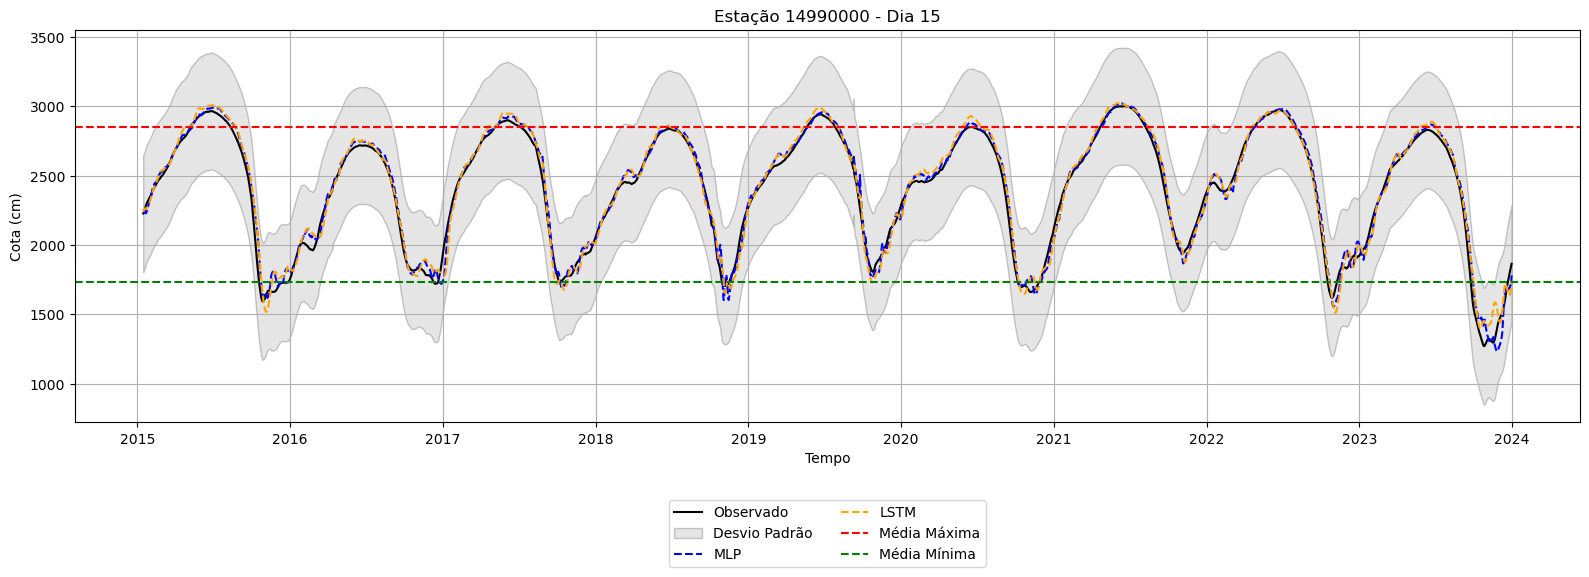

In [17]:
janela = 15
steps = 15

mlp = ann.build_model_mlp((30, 30), janela*3, steps)
lstm = ann.build_model_lstm(30, janela*3, steps)
train_test_model([mlp, lstm], ['MLP', 'LSTM'], negro, '14990000', date_split, janela, steps, lags_negro)

##### Rio Branco


Modelo: MLP
Médias: R² = 0.9514, RMSE = 62.3719, MAE = 48.6698, MAPE = 8.1811%
Dia 15: R² = 0.8887, RMSE = 102.0713, MAE = 80.5665, MAPE = 14.1813%

Modelo: LSTM
Médias: R² = 0.9442, RMSE = 67.7570, MAE = 50.4416, MAPE = 8.5030%
Dia 15: R² = 0.8828, RMSE = 104.7309, MAE = 80.2411, MAPE = 13.4316%


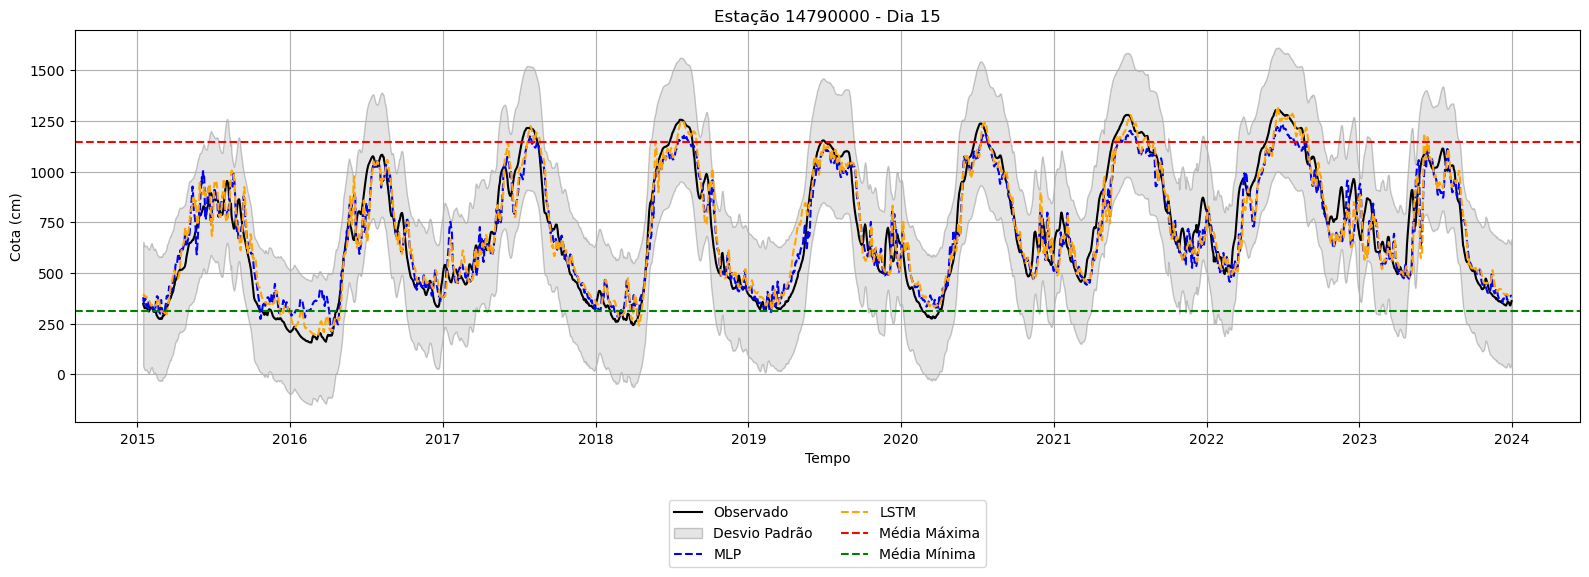

In [18]:
janela = 15
steps = 15

mlp = ann.build_model_mlp((30, 30), janela*3, steps)
lstm = ann.build_model_lstm(30, janela*3, steps)
train_test_model([mlp, lstm], ['MLP', 'LSTM'], branco, '14790000', date_split, janela, steps, lags_branco)